In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
os.environ['KERAS_BACKEND'] = "tensorflow"
import keras
import keras.layers as lay
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from src.generator import Generator
from src.discriminator import Discriminator
from src.aux_fn import train_step, train_step_wassertein, gradient_penalty

2025-09-04 23:39:32.672931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757029172.707065 3539999 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757029172.717888 3539999 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757029172.745206 3539999 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757029172.745234 3539999 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757029172.745237 3539999 computation_placer.cc:177] computation placer alr

In [2]:
(trainx,trainy),(_,_) = keras.datasets.cifar10.load_data()
trainx = trainx[trainy[:,0]==1]
trainx = (tf.cast(trainx,tf.float32)-127.5)/127.5
data4 = tf.data.Dataset.from_tensor_slices((trainx)).map(lambda x: tf.image.resize(x,(4,4))).cache().repeat(120).shuffle(2**10).map(lambda x: tf.image.random_flip_left_right(x)).batch(2**8,drop_remainder=True).prefetch(tf.data.AUTOTUNE)
data8 = tf.data.Dataset.from_tensor_slices((trainx)).map(lambda x: tf.image.resize(x,(8,8))).cache().repeat(120).shuffle(2**10).map(lambda x: tf.image.random_flip_left_right(x)).batch(2**8,drop_remainder=True).prefetch(tf.data.AUTOTUNE)
data16 = tf.data.Dataset.from_tensor_slices((trainx)).map(lambda x: tf.image.resize(x,(16,16))).cache().repeat(120).shuffle(2**10).map(lambda x: tf.image.random_flip_left_right(x)).batch(2**8,drop_remainder=True).prefetch(tf.data.AUTOTUNE)
data32 = tf.data.Dataset.from_tensor_slices((trainx)).map(lambda x: tf.image.resize(x,(32,32))).cache().repeat(120).shuffle(2**10).map(lambda x: tf.image.random_flip_left_right(x)).batch(2**8,drop_remainder=True).prefetch(tf.data.AUTOTUNE)

Cause: could not parse the source code of <function <lambda> at 0x7ae6701519e0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: tf.image.random_flip_left_right(x)

Match 1:
lambda x: tf.image.resize(x, (4, 4))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7ae6701519e0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: tf.image.random_flip_left_right(x)

Match 1:
lambda x: tf.image.resize(x, (4, 4))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <fun

I0000 00:00:1757029180.870017 3539999 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10262 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:04:00.0, compute capability: 8.6


Cause: could not parse the source code of <function <lambda> at 0x7ae6701539c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: tf.image.random_flip_left_right(x)

Match 1:
lambda x: tf.image.resize(x, (16, 16))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7ae6701539c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: tf.image.random_flip_left_right(x)

Match 1:
lambda x: tf.image.resize(x, (16, 16))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of 

In [3]:
gen = Generator(name='Generator')
dis = Discriminator(name='Discriminator')
gen.build()
dis.build()
# gen.summary()
# dis.summary()

In [4]:
bce = keras.losses.BinaryCrossentropy()
opt = [keras.optimizers.Adam(1e-4,.5) for i in range(2)]

# Treinamento 4x4

In [5]:
# for i in range(120+1):
for _ in range(2):
    for i,batch in enumerate(data4):
        gl, dl = train_step_wassertein([gen,dis],batch,bce,opt,gradient_penalty,stage=0)
        if i%234 == 0: print(f'EP = {i}; Gloss = {gl:.4f}; Dloss = {dl:.4f};')

/home/villeneve/venv311/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:857: UserWarning: Gradients do not exist for variables ['Generator/toRGB8/kernel', 'Generator/toRGB8/bias', 'Generator/toRGB16/kernel', 'Generator/toRGB16/bias', 'Generator/toRGB32/kernel', 'Generator/toRGB32/bias', 'Generator/block8_conv0/kernel', 'Generator/block8_conv0/bias', 'Generator/block8_conv1/kernel', 'Generator/block8_conv1/bias', 'Generator/block16_conv0/kernel', 'Generator/block16_conv0/bias', 'Generator/block16_conv1/kernel', 'Generator/block16_conv1/bias', 'Generator/block32_conv0/kernel', 'Generator/block32_conv0/bias', 'Generator/block32_conv1/kernel', 'Generator/block32_conv1/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
/home/villeneve/venv311/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:857: UserWarning: Gradients do not exist for variables ['Discriminator/fromRGB8/kernel', 'Di

EP = 0; Gloss = -0.0140; Dloss = 0.9450;
EP = 234; Gloss = 7.2005; Dloss = -1.4364;
EP = 468; Gloss = -1.1890; Dloss = -0.0515;
EP = 702; Gloss = 1.9102; Dloss = 0.1934;
EP = 936; Gloss = -2.9257; Dloss = 0.5191;
EP = 1170; Gloss = 0.2509; Dloss = 0.4232;
EP = 1404; Gloss = 1.4821; Dloss = -0.2793;
EP = 1638; Gloss = -2.4843; Dloss = -0.0488;
EP = 1872; Gloss = -0.9777; Dloss = 0.7041;
EP = 2106; Gloss = -1.7496; Dloss = 0.3062;
EP = 2340; Gloss = -0.7001; Dloss = 0.8201;
EP = 0; Gloss = 0.3639; Dloss = 0.1434;


2025-09-04 23:40:53.708102: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


EP = 234; Gloss = 1.4098; Dloss = 0.0539;
EP = 468; Gloss = 1.1054; Dloss = 0.4635;
EP = 702; Gloss = -0.1691; Dloss = 0.4270;
EP = 936; Gloss = 0.6093; Dloss = 0.1348;
EP = 1170; Gloss = 0.3300; Dloss = 0.4060;
EP = 1404; Gloss = 0.4733; Dloss = -0.1145;
EP = 1638; Gloss = 0.0412; Dloss = -0.1307;
EP = 1872; Gloss = -0.8555; Dloss = 0.3774;
EP = 2106; Gloss = -2.8241; Dloss = 0.1670;
EP = 2340; Gloss = -2.0355; Dloss = 0.1326;


2025-09-04 23:41:57.675620: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


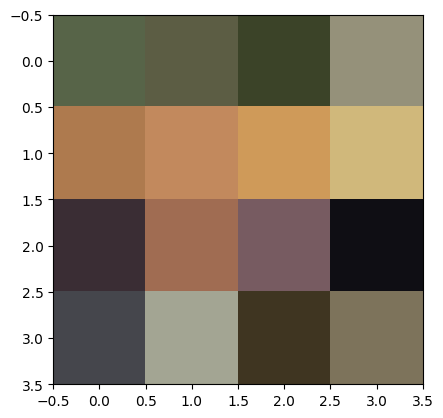

In [10]:
img = gen(tf.random.normal((1,128),0,1),stage=0)
img = np.uint8(img[0]*127.5+127.5)
plt.imshow(img)
plt.show()

# Treinamento 8x8

In [11]:
# for i in range(120+1):
    # gen.fade_in[0].alpha.assign(i/120.)
    # dis.fade_in[0].alpha.assign(i/120.)
for i,batch in enumerate(data8):
    gen.fade_in[0].alpha.assign(i/2344.)
    dis.fade_in[0].alpha.assign(i/2344.)
    gl, dl = train_step_wassertein([gen,dis],batch,bce,opt,gradient_penalty,stage=1)
    if i%234 == 0: print(f'EP = {i}; Gloss = {gl:.4f}; Dloss = {dl:.4f};')

gen.fade_in[0].alpha.assign(1.)
dis.fade_in[0].alpha.assign(1.)
for i,batch in enumerate(data8):
    gl, dl = train_step_wassertein([gen,dis],batch,bce,opt,gradient_penalty,stage=1)
    if i%234 == 0: print(f'EP = {i}; Gloss = {gl:.4f}; Dloss = {dl:.4f};')

/home/villeneve/venv311/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:857: UserWarning: Gradients do not exist for variables ['Generator/toRGB16/kernel', 'Generator/toRGB16/bias', 'Generator/toRGB32/kernel', 'Generator/toRGB32/bias', 'Generator/block16_conv0/kernel', 'Generator/block16_conv0/bias', 'Generator/block16_conv1/kernel', 'Generator/block16_conv1/bias', 'Generator/block32_conv0/kernel', 'Generator/block32_conv0/bias', 'Generator/block32_conv1/kernel', 'Generator/block32_conv1/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
/home/villeneve/venv311/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:857: UserWarning: Gradients do not exist for variables ['Discriminator/fromRGB16/kernel', 'Discriminator/fromRGB16/bias', 'Discriminator/fromRGB32/kernel', 'Discriminator/fromRGB32/bias', 'Discriminator/block16_conv0/kernel', 'Discriminator/block16_conv0/bias', 'Discrimin

EP = 0; Gloss = -2.2521; Dloss = 0.4793;
EP = 234; Gloss = -5.3648; Dloss = -2.8096;
EP = 468; Gloss = -5.2437; Dloss = -1.6231;
EP = 702; Gloss = -1.2154; Dloss = -1.2464;
EP = 936; Gloss = 4.0385; Dloss = -0.9162;
EP = 1170; Gloss = 4.8179; Dloss = -0.5972;
EP = 1404; Gloss = 10.5223; Dloss = -0.4503;
EP = 1638; Gloss = 4.4960; Dloss = -0.6961;
EP = 1872; Gloss = 0.4796; Dloss = -0.6119;
EP = 2106; Gloss = -0.5604; Dloss = -0.3766;
EP = 2340; Gloss = 16.2869; Dloss = 1.1548;
EP = 0; Gloss = 8.2796; Dloss = -0.4962;
EP = 234; Gloss = 4.6662; Dloss = 0.4136;
EP = 468; Gloss = 3.8101; Dloss = -0.3538;
EP = 702; Gloss = 4.7447; Dloss = 0.1835;
EP = 936; Gloss = 4.6458; Dloss = -0.0360;
EP = 1170; Gloss = 1.8724; Dloss = -0.2090;
EP = 1404; Gloss = 9.3406; Dloss = -0.0969;
EP = 1638; Gloss = 2.0450; Dloss = -0.4035;
EP = 1872; Gloss = 1.4921; Dloss = -0.5636;
EP = 2106; Gloss = -1.5579; Dloss = -0.1407;
EP = 2340; Gloss = -0.9699; Dloss = -0.1435;


2025-09-04 23:47:32.494669: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


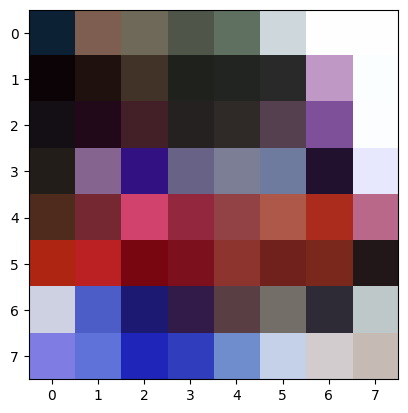

In [23]:
img = gen(tf.random.normal((1,128),0,1),stage=1)
img = np.uint8(img[0]*127.5+127.5)
plt.imshow(img)
plt.show()

# Treinamento 16x16

In [24]:
# for i in range(120+1):
    # gen.fade_in[1].alpha.assign(i/2344.)
    # dis.fade_in[1].alpha.assign(i/2344.)
for i,batch in enumerate(data16):
    gen.fade_in[1].alpha.assign(i/2344.)
    dis.fade_in[1].alpha.assign(i/2344.)
    gl, dl = train_step_wassertein([gen,dis],batch,bce,opt,gradient_penalty,stage=2)
    if i%234 == 0: print(f'EP = {i}; Gloss = {gl:.4f}; Dloss = {dl:.4f};')

gen.fade_in[1].alpha.assign(1.)
dis.fade_in[1].alpha.assign(1.)
for i,batch in enumerate(data16):
    gl, dl = train_step_wassertein([gen,dis],batch,bce,opt,gradient_penalty,stage=2)
    if i%234 == 0: print(f'EP = {i}; Gloss = {gl:.4f}; Dloss = {dl:.4f};')

/home/villeneve/venv311/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:857: UserWarning: Gradients do not exist for variables ['Generator/toRGB4/kernel', 'Generator/toRGB4/bias', 'Generator/toRGB32/kernel', 'Generator/toRGB32/bias', 'Generator/block32_conv0/kernel', 'Generator/block32_conv0/bias', 'Generator/block32_conv1/kernel', 'Generator/block32_conv1/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
/home/villeneve/venv311/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:857: UserWarning: Gradients do not exist for variables ['Discriminator/fromRGB4/kernel', 'Discriminator/fromRGB4/bias', 'Discriminator/fromRGB32/kernel', 'Discriminator/fromRGB32/bias', 'Discriminator/block32_conv0/kernel', 'Discriminator/block32_conv0/bias', 'Discriminator/block32_conv1/kernel', 'Discriminator/block32_conv1/bias'] when minimizing the loss. If using `model.compile()`, did you forget to 

EP = 0; Gloss = -0.5628; Dloss = -0.0296;
EP = 234; Gloss = 42.2521; Dloss = -3.4113;
EP = 468; Gloss = 36.8683; Dloss = -1.9125;
EP = 702; Gloss = 9.6288; Dloss = -1.6599;
EP = 936; Gloss = 35.7821; Dloss = -0.9298;
EP = 1170; Gloss = 17.5088; Dloss = -1.8307;
EP = 1404; Gloss = 24.5454; Dloss = -0.4890;
EP = 1638; Gloss = 7.5807; Dloss = -0.2793;
EP = 1872; Gloss = 6.8465; Dloss = -0.8644;
EP = 2106; Gloss = 5.4363; Dloss = -1.2715;
EP = 2340; Gloss = 13.4050; Dloss = -1.4559;
EP = 0; Gloss = 18.4181; Dloss = -0.8238;
EP = 234; Gloss = 5.5745; Dloss = -1.0289;
EP = 468; Gloss = 8.6876; Dloss = -0.9981;
EP = 702; Gloss = -0.0095; Dloss = -0.5843;
EP = 936; Gloss = 4.2418; Dloss = -0.7384;
EP = 1170; Gloss = 4.4124; Dloss = -0.5668;
EP = 1404; Gloss = 6.3762; Dloss = -1.0185;
EP = 1638; Gloss = -0.1772; Dloss = -0.6752;
EP = 1872; Gloss = 7.9635; Dloss = -0.7918;
EP = 2106; Gloss = 12.0966; Dloss = -0.8247;
EP = 2340; Gloss = 7.0967; Dloss = -0.6033;


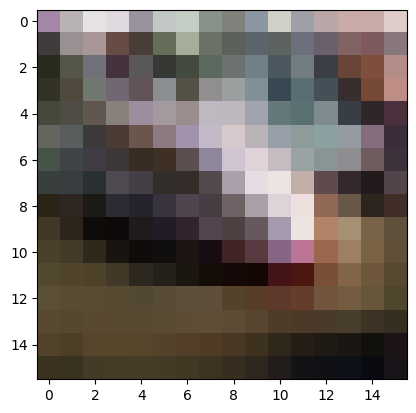

In [38]:
# keras.models.save_model(gen,'gen16.keras')
# keras.models.save_model(dis,'dis16.keras')
img = gen(tf.random.normal((1,128),0,1),stage=2)
img = np.uint8(img[0]*127.5+127.5)
plt.imshow(img)
plt.show()

# Treinamento 32x32

In [39]:
for i,batch in enumerate(data32):
    gen.fade_in[2].alpha.assign(i/2344.)
    dis.fade_in[2].alpha.assign(i/2344.)
    gl, dl = train_step_wassertein([gen,dis],batch,bce,opt,gradient_penalty,stage=3)
    if i%234 == 0: print(f'EP = {i}; Gloss = {gl:.4f}; Dloss = {dl:.4f};')

gen.fade_in[2].alpha.assign(1.)
dis.fade_in[2].alpha.assign(1.)
for i,batch in enumerate(data32):
    gl, dl = train_step_wassertein([gen,dis],batch,bce,opt,gradient_penalty,stage=3)
    if i%234 == 0: print(f'EP = {i}; Gloss = {gl:.4f}; Dloss = {dl:.4f};')

/home/villeneve/venv311/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:857: UserWarning: Gradients do not exist for variables ['Generator/toRGB4/kernel', 'Generator/toRGB4/bias', 'Generator/toRGB8/kernel', 'Generator/toRGB8/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
/home/villeneve/venv311/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:857: UserWarning: Gradients do not exist for variables ['Discriminator/fromRGB4/kernel', 'Discriminator/fromRGB4/bias', 'Discriminator/fromRGB8/kernel', 'Discriminator/fromRGB8/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


EP = 0; Gloss = 8.0540; Dloss = -1.1544;
EP = 234; Gloss = 51.2749; Dloss = -0.6110;
EP = 468; Gloss = 33.3950; Dloss = -4.2620;
EP = 702; Gloss = 50.7474; Dloss = -3.9240;
EP = 936; Gloss = 47.6638; Dloss = -4.6459;
EP = 1170; Gloss = 53.5484; Dloss = -3.7389;
EP = 1404; Gloss = 41.6530; Dloss = -5.6610;
EP = 1638; Gloss = 44.7739; Dloss = -4.3927;
EP = 1872; Gloss = 21.5324; Dloss = -1.5477;
EP = 2106; Gloss = 31.0303; Dloss = -2.4460;


KeyboardInterrupt: 

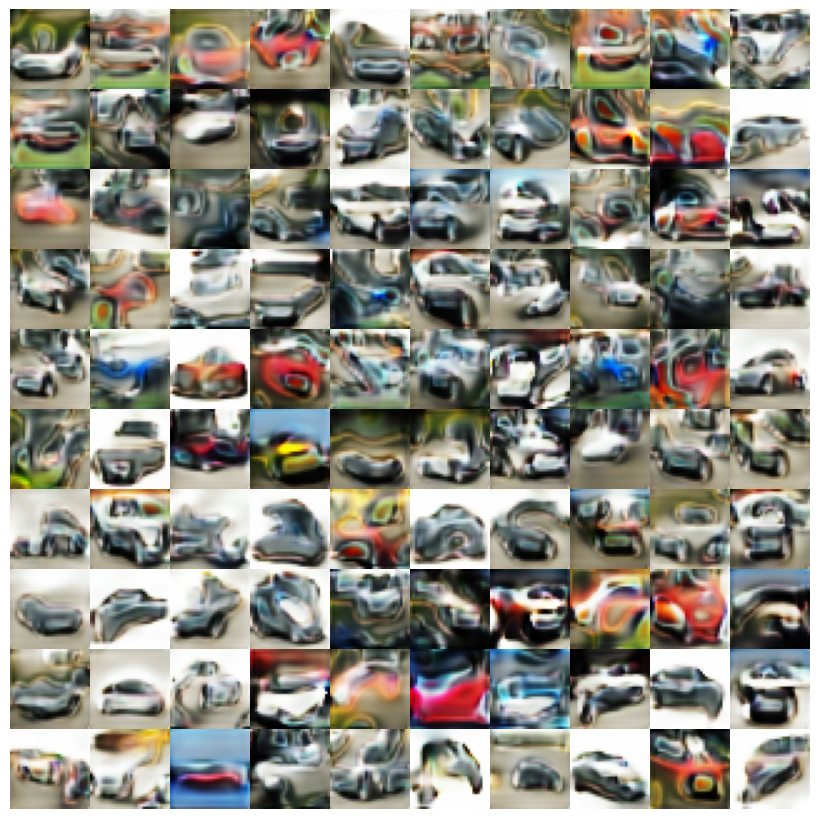

In [42]:
f = 10
# keras.models.save_model(gen,'gen32.keras')

imgs = gen(tf.random.normal((f**2,128),0,1),stage=3)
imgs = np.uint8(imgs*127.5+127.5)
fig, ax = plt.subplots(f,f,figsize=(8,8))
ax = ax.ravel()
for i in range(f*f):
    ax[i].imshow(imgs[i])
    ax[i].set_axis_off()
plt.tight_layout(pad=0)
plt.show()

In [ ]:
img = gen(tf.random.normal((1,128)),stage=3)
plt.imshow(np.uint8(img[0]*127.5+127.5))
plt.show()